# **Supervised KNN model**

___

**Outline:** 

i) Collect data 
    - stock ticker and adj close 
    
ii) Model construction 
    - Train supervised knn model to classify green / red days and make buy / sell decisions based on any pairwise combination or all 3 features 
        - Models independent variables / features -> RSI, Z-score, Stochastic Oscillator
        - Models dependant variables (values to be predicted) -> Trading day gain (green / red day)
            - Hypothesis is : "Feature extreme / high values should reflect statistical significant reversal points. Red days should be predicted for high positive values and green days for high negative values"
            
iii) Model Results and Optimization
    - Quantify the models performance, and attempt to optimize
    
iv) Backtest that strategy
    - backtest, creating buy and sell signals from model
        - BUY -> Today's asset close price is predicted positive  
        - SELL -> Today's Asset close price is predicted negative  

**I) Data Collection**

In [ ]:
# install needed library's
%pip install matplotlib
%pip install seaborn
%pip install yfinance
%pip install statsmodels  # install library for ACF plot

In [232]:
# library import
import os 
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt 
import seaborn as sb 
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
# data fetching import 
import yfinance as yf 

In [233]:
# get working directory
current_working_directory = os.getcwd()
print(current_working_directory) 

D:\PycharmProjects


In [234]:
# get stock data 
start_date, end_date = "2009-01-01", "2022-12-31"
ticker = "BTC-USD"
BTCUSD_data = yf.download(ticker, start = start_date, end = end_date)
df = BTCUSD_data[["Open", "High", "Low", "Close", "Adj Close", "Volume"]]
df = pd.DataFrame(BTCUSD_data)
print(df)

# subset for Adj Close only, note axis=0 is rows and axis=1 is columns
df_ml = df.loc[:, ["Adj Close", "High", "Low"]] # loc = all rows and specified columns
df_ml 

[*********************100%%**********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2014-09-17    465.864014    468.174011    452.421997    457.334015   
2014-09-18    456.859985    456.859985    413.104004    424.440002   
2014-09-19    424.102997    427.834991    384.532013    394.795990   
2014-09-20    394.673004    423.295990    389.882996    408.903992   
2014-09-21    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2022-12-26  16842.250000  16920.123047  16812.369141  16919.804688   
2022-12-27  16919.291016  16959.845703  16642.072266  16717.173828   
2022-12-28  16716.400391  16768.169922  16497.556641  16552.572266   
2022-12-29  16552.322266  16651.755859  16508.683594  16642.341797   
2022-12-30  16641.330078  16643.427734  16408.474609  16602.585938   

               Adj C

,Adj Close,High,Low
Date,,,
2014-09-17,457.334015,468.174011,452.421997
2014-09-18,424.440002,456.859985,413.104004
2014-09-19,394.795990,427.834991,384.532013
2014-09-20,408.903992,423.295990,389.882996
2014-09-21,398.821014,412.425995,393.181000
...,...,...,...
2022-12-26,16919.804688,16920.123047,16812.369141
2022-12-27,16717.173828,16959.845703,16642.072266
2022-12-28,16552.572266,16768.169922,16497.556641


In [235]:
# calculate returns & drop na's
df_ml["Returns"] = df_ml["Adj Close"].pct_change()
df_ml  = df_ml.dropna(axis=0)
df_ml = pd.DataFrame(df_ml)  
print(df_ml)

               Adj Close          High           Low   Returns
Date                                                          
2014-09-18    424.440002    456.859985    413.104004 -0.071926
2014-09-19    394.795990    427.834991    384.532013 -0.069843
2014-09-20    408.903992    423.295990    389.882996  0.035735
2014-09-21    398.821014    412.425995    393.181000 -0.024659
2014-09-22    402.152008    406.915985    397.130005  0.008352
...                  ...           ...           ...       ...
2022-12-26  16919.804688  16920.123047  16812.369141  0.004620
2022-12-27  16717.173828  16959.845703  16642.072266 -0.011976
2022-12-28  16552.572266  16768.169922  16497.556641 -0.009846
2022-12-29  16642.341797  16651.755859  16508.683594  0.005423
2022-12-30  16602.585938  16643.427734  16408.474609 -0.002389

[3026 rows x 4 columns]


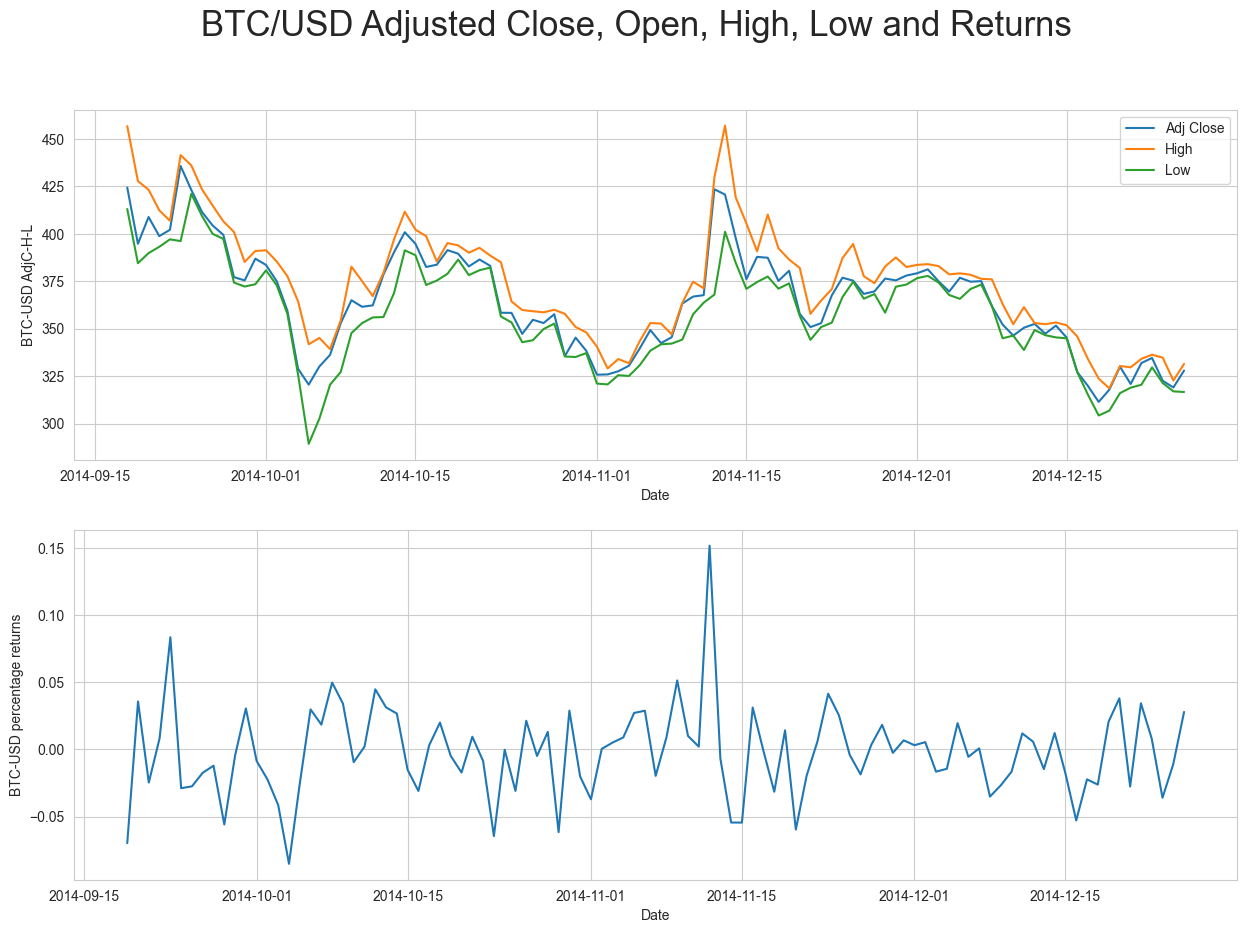

In [236]:
# vertical stack plots of stock price, high, low and returns 
fig, (ax00, ax01) = plt.subplots(2, figsize=(15, 10))

# Date and time variable, converted from index to column 
date = df_ml.index
date_subset = date[0:100]

# plot 1, price data 
ax00.plot(date_subset, df_ml.iloc[0:100, 0], label = "Adj Close")
ax00.plot(date_subset, df_ml.iloc[0:100, 1], label = "High")
ax00.plot(date_subset, df_ml.iloc[0:100, 2], label = "Low")
ax00.set_xlabel("Date")
ax00.set_ylabel("BTC-USD AdjC-H-L")
ax00.legend()

# plot 2, returns data 
ax01.plot(date_subset, df_ml["Adj Close"].pct_change()[0:100])
ax01.set_xlabel("Date")
ax01.set_ylabel("BTC-USD percentage returns")

# title 
fig.suptitle("BTC/USD Adjusted Close, Open, High, Low and Returns", fontsize=25)
plt.show()

**II) Model Collection**

In [238]:
"""REVERSAL INDICATORS
- RSI 
- Z-score 
- Stochastic
"""

# calculate RSI, Z score and add to BTCUSD ML data frame 
# RSI custom function that takes float and int types 
def RSI(returns: float, lookback: int):
    avg_gain = returns.where(returns > 0, 0).abs().rolling(window=lookback).mean()
    avg_loss = returns.where(returns < 0, 0).abs().rolling(window=lookback).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
# insensate rsi function 
data_returns = df_ml["Returns"]
rsi_lkb = 7
rsi = RSI(data_returns, rsi_lkb)
# append rsi indicator to data frame 
df_ml["RSI"] = rsi

# Z-score custom function that takes int and float types 
def ZScore(ma_lookback: int, std_lookback: int, close: float):
    rolling_mean = close.rolling(window=ma_lookback).mean() 
    rolling_std = close.rolling(window=std_lookback).std()
    zscore = (close - rolling_mean) / rolling_std # this is the z score equation 
    return zscore
# instantiate z-score function
ma_lkb = 7
std_lkb = 7
data_close = df_ml["Adj Close"]
z_score = ZScore(ma_lkb, std_lkb, data_close)
# append z-score indicator to data 
df_ml["Z score"] = z_score

# Stochastic Indicator that takes float and int types 
def Stoch(data: float, stock_lookback: int, stock_smooth_lookback: int):
    high_max = data["High"].rolling(window=stock_lookback).max()
    low_min = data["Low"].rolling(window=stock_lookback).min()
    k = 100 * ((data["Adj Close"] - low_min) / (high_max - low_min))
    ksmooth = k.rolling(window=stock_smooth_lookback).mean()
    return ksmooth   
# instantiate stochastic oscillator indicator 
stock_lkb = 14
stock_smooth_lkb = 3
stoch = Stoch(df_ml, stock_lkb, stock_smooth_lkb)
# append stoch indicator to data frame 
df_ml["Stoch"] = stoch

# clear all na values 
df_ml = df_ml.dropna(axis=0)
df_ml 

,Adj Close,High,Low,Returns,RSI,Z score,Stoch
Date,,,,,,,
2014-10-03,359.511993,377.695007,357.859009,-0.041485,17.415963,-1.629011,6.500989
2014-10-04,328.865997,364.487000,325.885986,-0.085243,12.294379,-2.041321,2.878933
2014-10-05,320.510010,341.800995,289.295990,-0.025408,14.013847,-1.534704,8.350519
2014-10-06,330.079010,345.134003,302.559998,0.029856,24.821112,-0.883111,16.620519
2014-10-07,336.187012,339.247009,320.481995,0.018505,20.901637,-0.462302,26.407968
...,...,...,...,...,...,...,...
2022-12-26,16919.804688,16920.123047,16812.369141,0.004620,82.922285,1.504954,24.563298
2022-12-27,16717.173828,16959.845703,16642.072266,-0.011976,30.066846,-1.760986,22.296715
2022-12-28,16552.572266,16768.169922,16497.556641,-0.009846,25.822507,-1.953400,18.146231


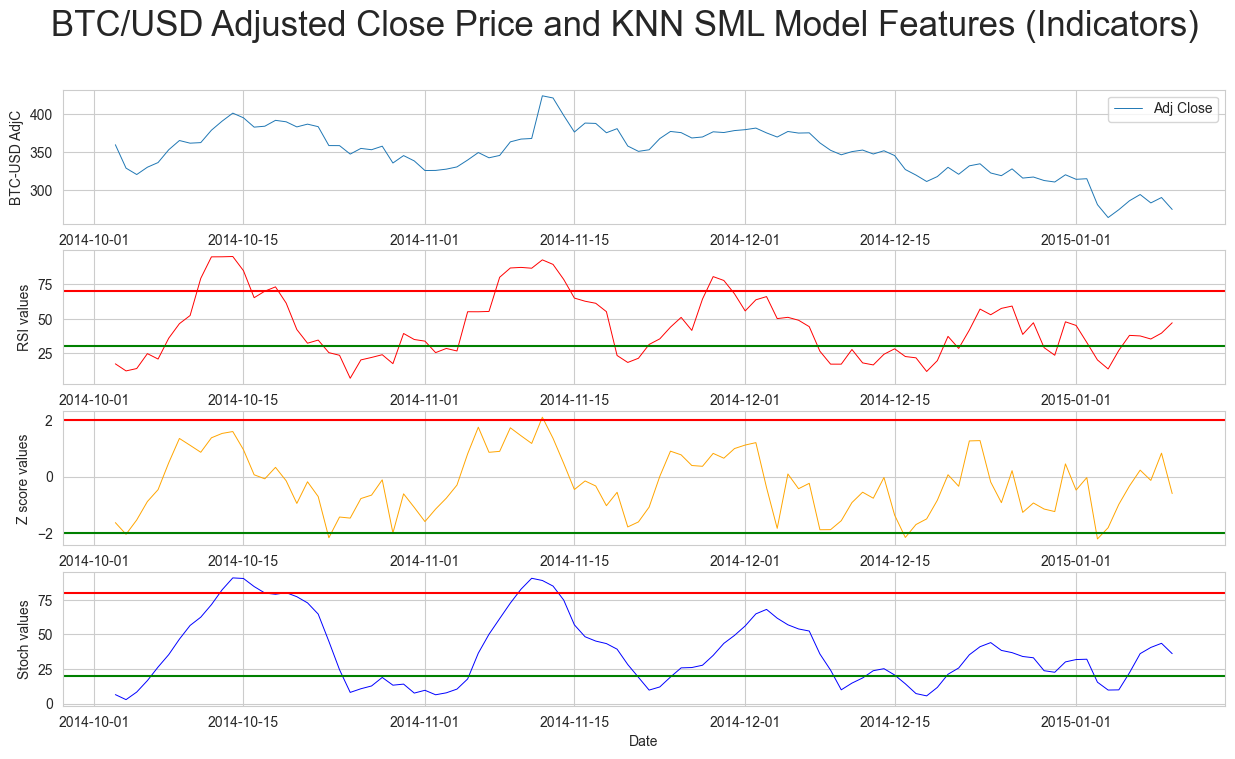

In [239]:
# plot indicators, first 100 observations only 
# vertical stack plots of stock price, high, low and returns 
fig, (ax00, ax01, ax02, ax03) = plt.subplots(4, figsize=(15, 8))

# Date and time variable, converted from index to column 
date = df_ml.index

# plot 1, price data 
ax00.plot(date[0:100], df_ml.iloc[0:100, 0], linewidth = 0.7, label = "Adj Close")
ax00.set_xlabel("")
ax00.set_ylabel("BTC-USD AdjC")
ax00.legend()

# plot 2, returns RSI
ax01.plot(date[0:100], df_ml.iloc[0:100, 4], linewidth = 0.7, c="red")
ax01.axhline(y=70, color="r", linestyle="-")
ax01.axhline(y=30, color="g", linestyle="-")
ax01.set_xlabel("")
ax01.set_ylabel("RSI values")

# plot 3, Z-score 
ax02.plot(date[0:100], df_ml.iloc[0:100, 5], linewidth = 0.7, c="orange")
ax02.axhline(y=2, color="r", linestyle="-")
ax02.axhline(y=-2, color="g", linestyle="-")
ax02.set_xlabel("")
ax02.set_ylabel("Z score values")

# plot 4, Stochastic 
ax03.plot(date[0:100], df_ml.iloc[0:100, 6], linewidth = 0.7, c="blue")
ax03.axhline(y=80, color="r", linestyle="-")
ax03.axhline(y=20, color="g", linestyle="-")
ax03.set_xlabel("Date")
ax03.set_ylabel("Stoch values")

# title 
fig.suptitle("BTC/USD Adjusted Close Price and KNN SML Model Features (Indicators)", fontsize=25)
plt.show()

Text(0.5, 1.0, 'ML Model Features (Indicators) Correlation Matrix Heatmap')

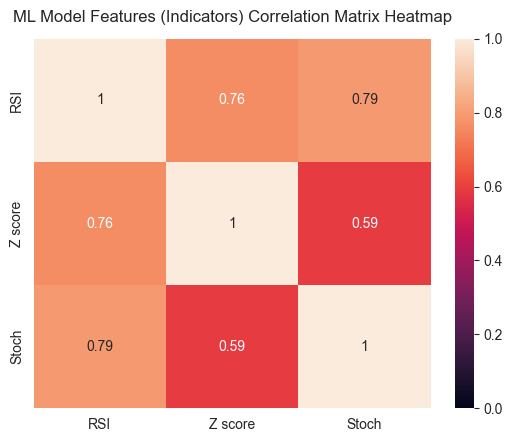

In [240]:
# get correlation of indicators 
indicators = df_ml[["RSI", "Z score", "Stoch"]]
heatmap = sb.heatmap(indicators.corr(), vmin = 0, vmax = 1, annot = True)
heatmap.set_title("ML Model Features (Indicators) Correlation Matrix Heatmap", fontdict={"fontsize":12}, pad=12)

In [242]:
# Append the Dependent variable classifier, this is if the days are green or red close days 
def DayClass(data, returns):
    data["Day Class"] = ""
    for i in range(len(returns)):
        if (returns.iloc[i][0]) > 0:
            data["Day Class"][i] = "green"
        else:
            data["Day Class"][i] = "red"
    return data

# instentiate new data frame with new values column 
data_returns = df_ml[["Returns"]]
df_ml = DayClass(df_ml.copy(), data_returns) 
df_ml 

C:\Users\amjad\AppData\Local\Temp\ipykernel_40516\1442570181.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (returns.iloc[i][0]) > 0:
C:\Users\amjad\AppData\Local\Temp\ipykernel_40516\1442570181.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Day Class"][i] = "red"
C:\Users\amjad\AppData\Local\Temp\ipykernel_40516\1442570181.py:8: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  data["Day Class"][i] = "red"
C:\Use

,Adj Close,High,Low,Returns,RSI,Z score,Stoch,Day Class
Date,,,,,,,,
2014-10-03,359.511993,377.695007,357.859009,-0.041485,17.415963,-1.629011,6.500989,red
2014-10-04,328.865997,364.487000,325.885986,-0.085243,12.294379,-2.041321,2.878933,red
2014-10-05,320.510010,341.800995,289.295990,-0.025408,14.013847,-1.534704,8.350519,red
2014-10-06,330.079010,345.134003,302.559998,0.029856,24.821112,-0.883111,16.620519,green
2014-10-07,336.187012,339.247009,320.481995,0.018505,20.901637,-0.462302,26.407968,green
...,...,...,...,...,...,...,...,...
2022-12-26,16919.804688,16920.123047,16812.369141,0.004620,82.922285,1.504954,24.563298,green
2022-12-27,16717.173828,16959.845703,16642.072266,-0.011976,30.066846,-1.760986,22.296715,red
2022-12-28,16552.572266,16768.169922,16497.556641,-0.009846,25.822507,-1.953400,18.146231,red


[7] [8] [10]


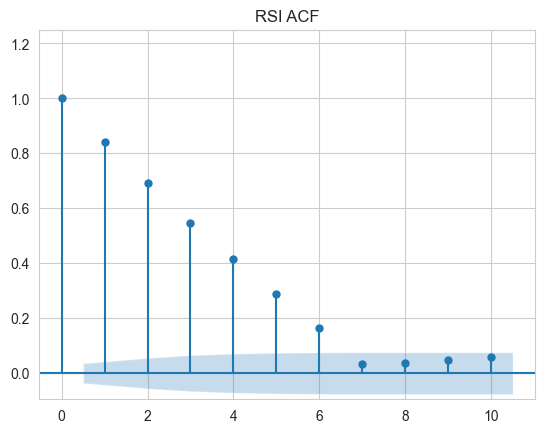

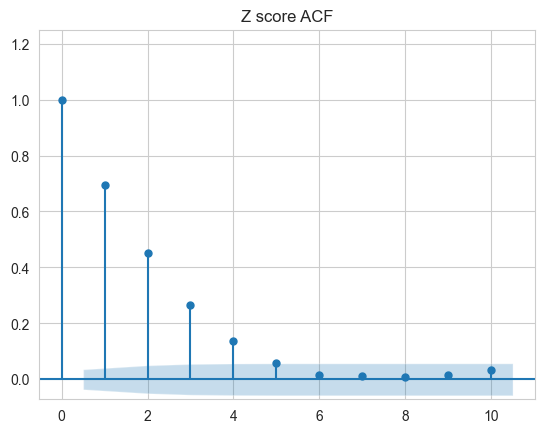

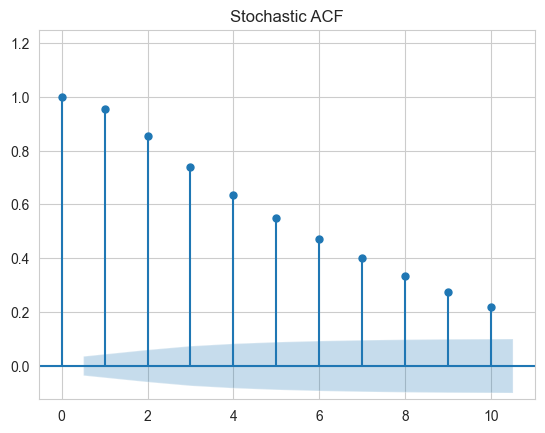

In [243]:
# the SML model is ment to predict today's current state given the feature values of lag days ago, to determine the optimal lag,  
# shifting features (indicators) k lag's in the future (the interpretation is k days ago indicator values are used to predict today)
# also clear na's rows  

# To find the optimal lag plot the ACF of the features, the lag that gives the largest negative correlation should be chosen for each feature, the intuition is that there is strong negative correlation with feature vales t-k lags ago and feature values at time t
plot_acf(df_ml["RSI"], lags=10, title = "RSI ACF", auto_ylims=True)
plot_acf(df_ml["Z score"], lags=10, title = "Z score ACF", auto_ylims=True)
plot_acf(df_ml["Stoch"], lags=10, title = "Stochastic ACF", auto_ylims=True)

# array of the lags 
rsi_acf_array = sm.graphics.tsa.acf(df_ml["RSI"], nlags=10)
zscore_acf_array = sm.graphics.tsa.acf(df_ml["Z score"], nlags=10)
stoch_acf_array = sm.graphics.tsa.acf(df_ml["Stoch"], nlags=10)

# function that gets optimal acf lags 
def OptLag(acf):
    min_acf = acf.min()
    k = []
    for opt_lag, acf in enumerate(acf):
        if acf == min_acf:
            k.append(opt_lag) 
    return k

# get optimal lag for each feature 
rsi_lag = OptLag(rsi_acf_array)
zscore_lag = OptLag(zscore_acf_array)
stoch_lag = OptLag(stoch_acf_array)
print(rsi_lag, zscore_lag, stoch_lag)

In [244]:
df_ml[["RSI"]] = df_ml[["RSI"]].shift(rsi_lag)
df_ml[["Z score"]] = df_ml[["Z score"]].shift(zscore_lag)
df_ml[["Stoch"]] = df_ml[["Stoch"]].shift(stoch_lag)

# clear na rows
df_ml = df_ml.dropna(axis = 0)
df_ml 

,Adj Close,High,Low,Returns,RSI,Z score,Stoch,Day Class
Date,,,,,,,,
2014-10-13,390.414001,397.226013,368.897003,0.031343,24.821112,-1.534704,6.500989,green
2014-10-14,400.869995,411.697998,391.324005,0.026782,20.901637,-0.883111,2.878933,green
2014-10-15,394.773010,402.226990,388.765991,-0.015209,36.020822,-0.462302,8.350519,red
2014-10-16,382.556000,398.807007,373.070007,-0.030947,46.538534,0.489937,16.620519,red
2014-10-17,383.757996,385.477997,375.389008,0.003142,52.433869,1.349218,26.407968,green
...,...,...,...,...,...,...,...,...
2022-12-26,16919.804688,16920.123047,16812.369141,0.004620,33.484283,-0.903070,36.909143,green
2022-12-27,16717.173828,16959.845703,16642.072266,-0.011976,30.851555,-1.149807,18.311305,red
2022-12-28,16552.572266,16768.169922,16497.556641,-0.009846,28.584039,-0.115955,8.583102,red


In [275]:
# To eliminate indicator noise, and test the true predictive power of all indicators 
# all intermediate values (values which are not reversal values) from all indicators must be removed before training and testing sets are created

# these are the filtering values
# for RSI 
threshold_RSI_H = 70
threshold_RSI_L = 30
# for Z score 
threshold_Z_score_H = 1.5
threshold_Z_score_L = -1.5
# for Stochastic
threshold_stoch_H = 80
threshold_stoch_L = 20

# data filtering function, filters data, substituting original data for reversals 
def filter_data(data, column1, column2, column3, threshold11, threshold12, threshold21, threshold22, threshold31, threshold32, threefeature=False):
    # function 
    filtered_df_ml = pd.DataFrame()
    # iterate over original rows
    for i in range(len(data)):
        row1 = column1.iloc[i] # rsi 
        row2 = column2.iloc[i] # zscore
        row3 = column3.iloc[i] # stoch
        # check for specified column if value >< threshold, check this for every combination (not permutation as order does not matter)of indicator 
        if not threefeature:
            if ((row1 > threshold11) and (row2 > threshold21)) or ((row1 < threshold12) and (row2 < threshold22)):
                filtered_df_ml = filtered_df_ml._append(data.iloc[i][["RSI", "Z score", "Day Class", "Returns"]])
            # may combine to above if statement
            elif ((row1 > threshold11) and (row3 > threshold31)) or ((row1 < threshold12) and (row3 < threshold32)):
                filtered_df_ml = filtered_df_ml._append(data.iloc[i][["RSI", "Stoch", "Day Class", "Returns"]])
            elif ((row2 > threshold21) and (row3 > threshold31)) or ((row2 < threshold22) and (row3 < threshold32)):
                filtered_df_ml = filtered_df_ml._append(data.iloc[i][["Z score", "Stoch", "Day Class", "Returns"]])   
        else:
            if (row1 > threshold11 and row2 > threshold21 and row3 > threshold31) or (row1 < threshold12 and row2 < threshold22 and row3 < threshold32) :
                filtered_df_ml = filtered_df_ml._append(data.iloc[i][["Returns", "RSI", "Z score", "Stoch", "Day Class"]])
    return filtered_df_ml

df_ml_new = filter_data(df_ml, df_ml["RSI"], df_ml["Z score"], df_ml["Stoch"], threshold_RSI_H, threshold_RSI_L, threshold_Z_score_H, threshold_Z_score_L, threshold_stoch_H, threshold_stoch_L, threefeature=True)
print(df_ml_new.shape)
df_ml_new

(144, 5)


,Returns,RSI,Z score,Stoch,Day Class
2014-10-13,0.031343,24.821112,-1.534704,6.500989,green
2014-11-09,0.051452,25.553423,-1.591100,14.086267,green
2014-11-20,-0.059689,89.495607,2.100992,82.587809,red
2015-04-21,0.047381,1.394684,-1.632187,14.718444,green
2015-04-22,-0.004646,17.317819,-1.615985,12.016418,red
...,...,...,...,...,...
2022-09-03,-0.006895,27.922752,-2.160234,13.647128,red
2022-09-04,0.007797,12.817880,-1.612948,15.220725,green
2022-11-28,-0.013822,21.234385,-2.010013,17.386976,red
2022-11-29,0.014038,28.930512,-1.993334,17.737130,green


***III) Model Results and Optimization**

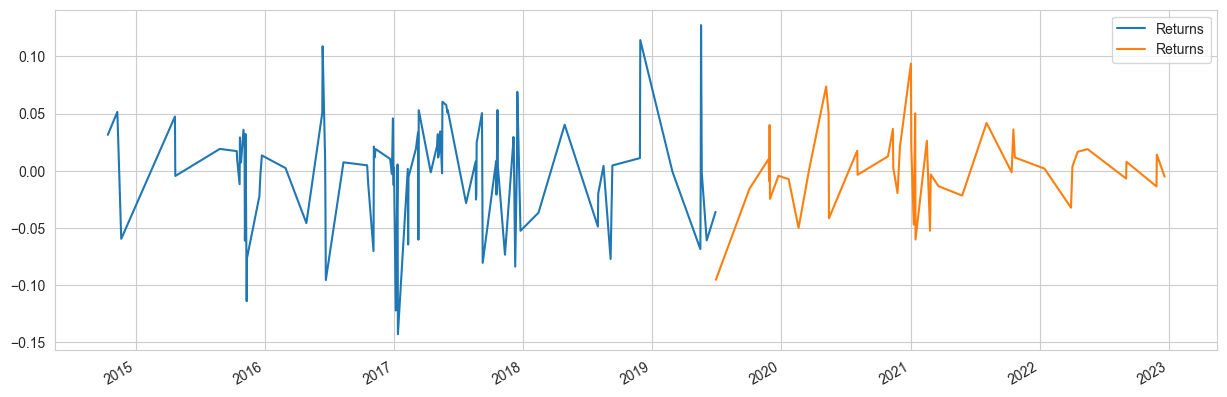

<bound method NDFrame.head of                   RSI   Z score      Stoch
2014-10-13  24.821112 -1.534704   6.500989
2014-11-09  25.553423 -1.591100  14.086267
2014-11-20  89.495607  2.100992  82.587809
2015-04-21   1.394684 -1.632187  14.718444
2015-04-22  17.317819 -1.615985  12.016418
...               ...       ...        ...
2022-09-03  27.922752 -2.160234  13.647128
2022-09-04  12.817880 -1.612948  15.220725
2022-11-28  21.234385 -2.010013  17.386976
2022-11-29  28.930512 -1.993334  17.737130
2022-12-21  89.523522  2.034294  80.649393

[144 rows x 3 columns]>
[1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1
 1 0 1 0 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0
 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1
 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0]
(100, 3)
(44, 3)


In [277]:
# Split data for KNN model, 70-30% split model 
split_percentage = 0.7
split = int(split_percentage*len(df_ml_new))

train = df_ml_new.iloc[:split][["Returns"]]
test = df_ml_new.iloc[split:][["Returns"]]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label = "Train Set")
test.plot(ax=ax, label = "Test Set")
plt.legend()
plt.show()

# Create data frame with all training data & drop dependent variable & extra variables
x = df_ml_new.drop(columns=["Day Class", "Returns"])
print(x.head)

# Get the seperated dependant variable, and change variable from categorical to discrete 
y = np.where(df_ml_new["Day Class"] == "green", 1, 0)
print(y)

# new data sets where data is split into training and testing data sets 
x_train, x_test, y_train, y_test =  train_test_split(x, y, test_size=(1-split_percentage), shuffle = False)
# check dimensions
print(x_train.shape)
print(x_test.shape)

Text(0.5, 1.0, 'Stochastic Oscillator Reversal Values and Day State Across Time')

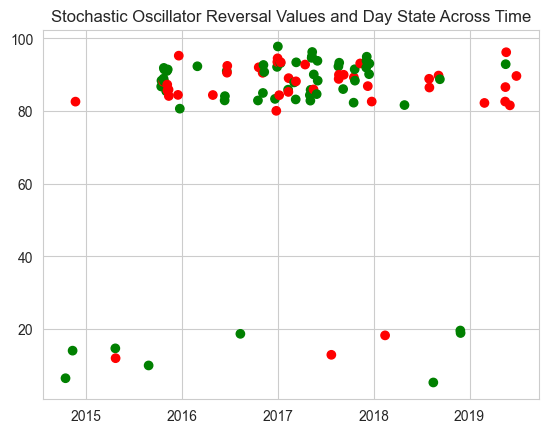

In [278]:
# transform the y variable back to orginal 
day_class = np.where(y_train == 1, "green", "red")
plt.scatter(x_train.index, x_train["Stoch"], c=day_class)
plt.title("Stochastic Oscillator Reversal Values and Day State Across Time")

Text(0, 0.5, 'Z score')

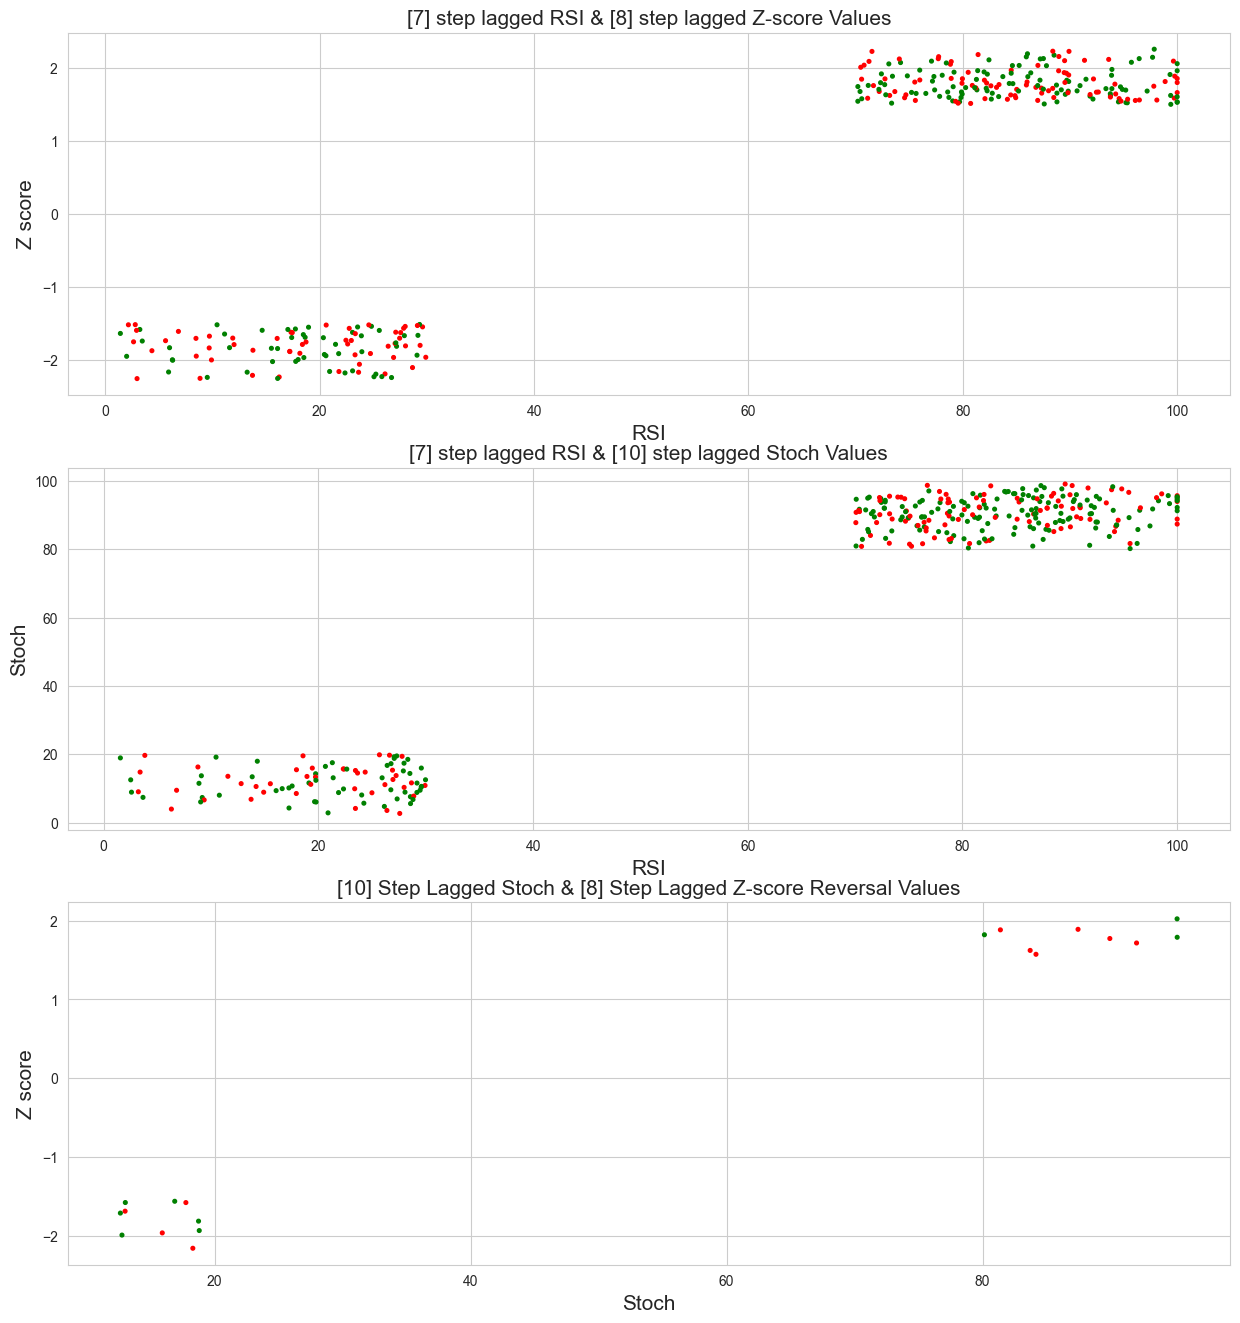

In [274]:
# visualise data before creating model, does hypothesis hold ?
# visualise different combinations of indicators, as model has only two features
# select the model that categorises day green / red days best 

fig, (ax00, ax10, ax01) = plt.subplots(3, figsize=(15, 16))

# RSI & Z-score 
ax00.scatter(x_train["RSI"], x_train["Z score"], color = day_class, s = 7)
ax00.set_title(f"{rsi_lag} step lagged RSI & {zscore_lag} step lagged Z-score Values", fontsize = 15)
ax00.set_xlabel("RSI", fontsize = 15)
ax00.set_ylabel("Z score", fontsize = 15)

# RSI & Stoch 
ax10.scatter(x_train["RSI"], x_train["Stoch"], color = day_class, s = 7)
ax10.set_title(f"{rsi_lag} step lagged RSI & {stoch_lag} step lagged Stoch Values", fontsize = 15)
ax10.set_xlabel("RSI", fontsize = 15)
ax10.set_ylabel("Stoch", fontsize = 15)

# Z-score & Stoch 
ax01.scatter(x_train["Stoch"], x_train["Z score"], color = day_class, s = 7)
ax01.set_title(f"{stoch_lag} Step Lagged Stoch & {zscore_lag} Step Lagged Z-score Reversal Values", fontsize = 15)
ax01.set_xlabel("Stoch", fontsize = 15)
ax01.set_ylabel("Z score", fontsize = 15)

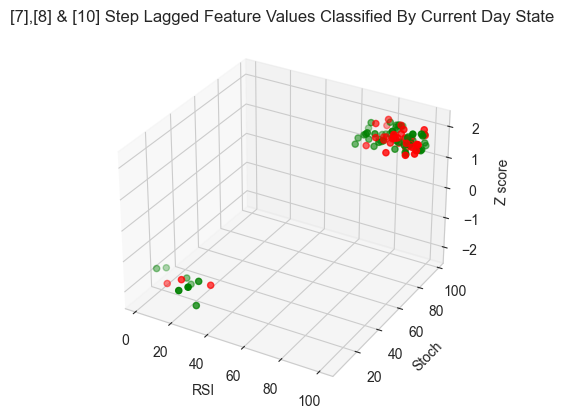

In [279]:
# Declare and assign axis values 
x = x_train['RSI']
y = x_train['Stoch']
z = x_train['Z score']

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot the data
ax.scatter3D(x, y, z, c=day_class)
# Set labels
ax.set_xlabel('RSI')
ax.set_ylabel('Stoch')
ax.set_zlabel('Z score')
# Set title
ax.set_title(f'{rsi_lag},{zscore_lag} & {stoch_lag} Step Lagged Feature Values Classified By Current Day State')
# Show the plot
plt.show()

In [280]:
# fit the knn model
# creating the KNN classifier, declare object knn which is an instanced class
knn = KNeighborsClassifier(n_neighbors=3)
# fit the classifier to the data (out of sample features)
knn.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [282]:
# test the knn model, will predict the dependent variable (day class)
state_predictions = knn.predict(x_test)
# evaluate model 
knn.score(x_test, y_test)

0.5454545454545454

[ 1  2  3  4  5  6  7  8  9 10] 
 [0.5, 0.45454545454545453, 0.5454545454545454, 0.4318181818181818, 0.5454545454545454, 0.5, 0.5227272727272727, 0.5227272727272727, 0.5, 0.5227272727272727]


Text(0.5, 1.0, 'KNN SML Model Accuracy Score for Varying Number of Neighbors')

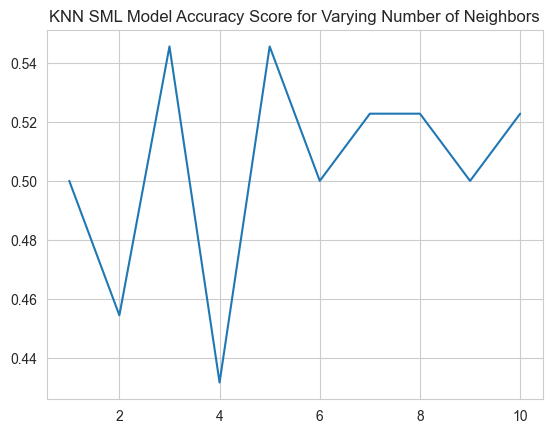

In [283]:
# optimize model by fitting / predicting knn models with different lags 
neighbors = np.arange(1, 11)
test_accuracies = []

# find optimal neighbors
for neighbor in neighbors:
	# Set up a KNN Classifier
	knn = KNeighborsClassifier(n_neighbors=neighbor)
	#Fit the model
	knn.fit(x_train, y_train)
	# Compute accuracy
	test_accuracies.append(knn.score(x_test, y_test))
print(neighbors, '\n', test_accuracies)
plt.plot(neighbors, test_accuracies)
plt.title("KNN SML Model Accuracy Score for Varying Number of Neighbors")

**IV) Backtest the Strategy**

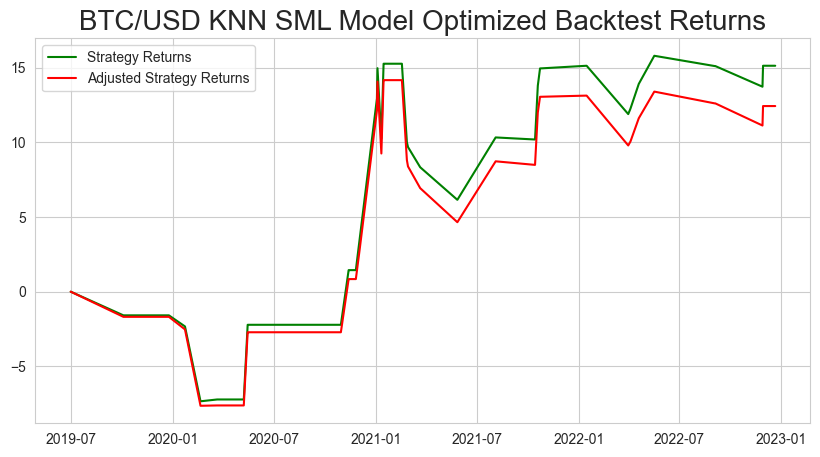

In [287]:
# backtest 
# the prediction trading signal
# note splits are exclusive, half open intervals splits insure no data loss
x_test["Signals (Long Only)"] = state_predictions
x_test["Returns"] = df_ml_new[100:][["Returns"]]

# strategy cumulative returns
x_test['Strategy returns'] = x_test['Signals (Long Only)'] * x_test['Returns']
Cumulative_Strategy_returns = x_test['Strategy returns'].cumsum()*100

# add commission adjusted returns 
x_test["Strategy returns (Commission adjusted)"] = x_test['Signals (Long Only)'] * (x_test['Returns'] - 0.001)
Cumulative_Strategy_returns_commission_adjusted = x_test['Strategy returns (Commission adjusted)'].cumsum()*100

# plotting strategy results 
plt.figure(figsize=(10,5))
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.plot(Cumulative_Strategy_returns_commission_adjusted, color='red', label = 'Adjusted Strategy Returns')
plt.title("BTC/USD KNN SML Model Optimized Backtest Returns", fontsize=20)
plt.legend()
plt.show()